# Spotify NB 6: clustering
# Set up

In [1]:
%reset -fs

In [2]:
import pandas as pd
import numpy as np
import math
import pickle

from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from random import randrange

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.decomposition import PCA

import sklearn as skl
import sklearn.metrics as skl_m
import sklearn.cluster as skl_c
import sklearn.preprocessing as skl_p
import sklearn.model_selection as skl_ms

%matplotlib inline
plt.style.use('seaborn')
sns.set(style="whitegrid", palette="viridis", color_codes=True)

RSEED=np.random.seed(42)

## Data cleaning & feature engineering
The data was cleaned in the course of the EDA. Additional features were created and the new dataset was saved to a csv, that will be the starting point for this notebook. For further information on the data cleaning please refer to the respective notebook (Spotify_2019_EDA).

In [3]:
data = pd.read_csv('data/tracks_2019_cleaned.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

In [4]:
df=data.copy()
df.shape

(347865, 28)

# Clustering (unsupervised)

## Preprocessing

In [5]:
# Defining categorical features for preprocessing
categoric_features = list(df.columns[df.dtypes == object])+ list(df.columns[df.dtypes == bool])
exclude = ['album', 'artists', 'artists_id', 'available_markets','cover_url', 'name',
           'preview_url', 'release_date', 'track_id', 'genres']
categoric_features = [df for df in categoric_features if df not in exclude]
categoric_features

['main_genres']

In [6]:
# Defining numerical features for preprocessing
numeric_features = list(df.columns[df.dtypes!=object])
exclude =list(df.columns[df.dtypes == bool])+['popularity', 'month', 'no_genres', 'place_in_album', 'total_album_tracks', 'album_track_no']
numeric_features = [df for df in numeric_features if df not in exclude]
numeric_features

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'time_signature']

In [7]:
# Assining X
X=df[numeric_features +categoric_features]

In [8]:
# Creating transforming pipes to preprocess both categorical and numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', skl_p.StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', skl_p.OneHotEncoder(drop='first'))])

# Combining the preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categoric_features)])

# Adding dimensionality reduction to the preprocessing
pca_preprocessor = Pipeline([('preprocessor', preprocessor),
                        ('pca', PCA(n_components=2, random_state=RSEED))])

## DBSCAN

In [9]:
# looping through DBSCAN hyperparameter for optimisation
results = pd.DataFrame(columns=['eps', 'min_samples', 'clusters', 'noise points'])
i=0

eps = [0.01, 0.1]#, 0.5, 0.7, 1, 1.5, 2, 3, 5]
samples = [25, 50, 100, 200, 500]

for e in eps:
    for s in samples:
        dbscan_pipe = Pipeline([('pca_preprocessor', pca_preprocessor),
                                ('db', skl_c.DBSCAN(eps=e, 
                                                    min_samples=s,
                                                    n_jobs=-1))])
        dbscan_pipe.fit(X)
        
        # Number of clusters in labels, ignoring noise if present.
        labels = dbscan_pipe.named_steps['db'].labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        temp = pd.DataFrame({
            'eps': e,
            'min_samples': s,
            'clusters': n_clusters,
            'noise points' : n_noise,
            },
            index=[i])
        i += 1
        print('step '+str(i)+' /'+ str(len(eps)*len(samples)))

        results = pd.concat([results, temp])

step 1 /10
step 2 /10
step 3 /10
step 4 /10
step 5 /10
step 6 /10
step 7 /10
step 8 /10
step 9 /10
step 10 /10


In [10]:
results.round(2)

,eps,min_samples,clusters,noise points
0,0.01,25,67,345500
1,0.01,50,3,347604
2,0.01,100,1,347738
3,0.01,200,0,347865
4,0.01,500,0,347865
5,0.10,25,12,5912
6,0.10,50,4,11239
7,0.10,100,5,23219
8,0.10,200,5,54218
9,0.10,500,3,135715


DBSCAN fails to divide the data reliably into clusters that can be used as recommedations.


## K-Means

In [11]:
# Building a full pipeline with our preprocessor (including pca) and K-Means clsutering
kmeans_pipe = Pipeline([('pca_preprocessor', pca_preprocessor),
                        ('kmeans', skl_c.KMeans(n_clusters=1000,
                                      n_init=50,
                                      max_iter=500,
                                      verbose=5,
                                      random_state=RSEED,
                                      n_jobs=-1))])

In [12]:
# fitting the pipe
kmeans_pipe.fit(X)

# saving the model
pickle.dump(kmeans_pipe, open('Pickles/kmeans_pipe.pkl', 'wb'))

/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Initialization complete
Iteration 0, inertia 2716.0540617098122
Iteration 1, inertia 2503.6483088569266
Iteration 2, inertia 2453.4228639337316
Iteration 3, inertia 2427.1693909754713
Iteration 4, inertia 2409.42705244552
Iteration 5, inertia 2397.8768728109167
Iteration 6, inertia 2389.3383085510286
Iteration 7, inertia 2382.5853393522434
Iteration 8, inertia 2377.0464566614837
Iteration 9, inertia 2372.456624869512
Iteration 10, inertia 2368.411356979983
Iteration 11, inertia 2364.84513432429
Iteration 12, inertia 2361.8858295204764
Iteration 13, inertia 2359.2015822919707
Iteration 14, inertia 2356.7282431864196
Iteration 15, inertia 2354.291887271585
Iteration 16, inertia 2351.9053707629123
Iteration 17, inertia 2349.7255255853734
Iteration 18, inertia 2347.6122232131474
Iteration 19, inertia 2345.617917531809
Iteration 20, inertia 2343.830399671379
Iteration 21, inertia 2342.328015645714
Iteration 22, inertia 2341.085498651101
Iteration 23, inertia 2339.985034173885
Iteration 24, 

Iteration 52, inertia 2321.673801890736
Iteration 53, inertia 2321.453778269416
Iteration 54, inertia 2321.222325900005
Iteration 55, inertia 2321.010486571388
Iteration 56, inertia 2320.8301041779937
Iteration 57, inertia 2320.6297413090715
Iteration 58, inertia 2320.444869019973
Iteration 59, inertia 2320.2394255101426
Iteration 60, inertia 2320.0644263508852
Iteration 61, inertia 2319.8960084606615
Iteration 62, inertia 2319.721021922969
Iteration 63, inertia 2319.5270500124266
Iteration 64, inertia 2319.3733289974516
Iteration 65, inertia 2319.2377344105244
Iteration 66, inertia 2319.0999258009674
Iteration 67, inertia 2318.950760792536
Iteration 68, inertia 2318.8158681679956
Iteration 69, inertia 2318.682162087402
Iteration 70, inertia 2318.5522689791233
Iteration 71, inertia 2318.4322123302386
Converged at iteration 71: center shift 0.00019514367952698432 within tolerance 0.00022058755025473393
Initialization complete
Iteration 0, inertia 2725.007347294468
Iteration 1, inertia 2

Iteration 54, inertia 2313.614262300488
Iteration 55, inertia 2313.343243699506
Iteration 56, inertia 2313.0960395651937
Iteration 57, inertia 2312.814822770447
Iteration 58, inertia 2312.5115747994664
Iteration 59, inertia 2312.237177966284
Iteration 60, inertia 2311.972386699986
Iteration 61, inertia 2311.7275227652576
Iteration 62, inertia 2311.5005955054494
Iteration 63, inertia 2311.3023494274807
Iteration 64, inertia 2311.1263908098476
Iteration 65, inertia 2310.961599633824
Iteration 66, inertia 2310.79480968472
Iteration 67, inertia 2310.6245375116882
Converged at iteration 67: center shift 0.00021036108768533092 within tolerance 0.00022058755025473393
Initialization complete
Iteration 0, inertia 2723.7196180187925
Iteration 1, inertia 2503.681433900805
Iteration 2, inertia 2452.5736378069205
Iteration 3, inertia 2427.2613279599773
Iteration 4, inertia 2411.9201526401093
Iteration 5, inertia 2401.058747504476
Iteration 6, inertia 2392.3410188230123
Iteration 7, inertia 2384.726

Iteration 4, inertia 2405.9583280185334
Iteration 5, inertia 2393.1424445878533
Iteration 6, inertia 2383.735120678162
Iteration 7, inertia 2376.179591706084
Iteration 8, inertia 2369.3892890213883
Iteration 9, inertia 2363.5649678129707
Iteration 10, inertia 2358.5943914028053
Iteration 11, inertia 2354.18371663149
Iteration 12, inertia 2350.4031241984035
Iteration 13, inertia 2347.0875780833917
Iteration 14, inertia 2344.2348726257114
Iteration 15, inertia 2341.797787442495
Iteration 16, inertia 2339.6734794069607
Iteration 17, inertia 2337.7423856368887
Iteration 18, inertia 2336.1280587712085
Iteration 19, inertia 2334.602125751625
Iteration 20, inertia 2333.159568572896
Iteration 21, inertia 2331.7724707042416
Iteration 22, inertia 2330.5180546992055
Iteration 23, inertia 2329.422828676265
Iteration 24, inertia 2328.387417828341
Iteration 25, inertia 2327.447965775703
Iteration 26, inertia 2326.6447695964575
Iteration 27, inertia 2325.9370146584392
Iteration 28, inertia 2325.28610

Iteration 7, inertia 2371.380739011164
Iteration 8, inertia 2364.9807452143855
Iteration 9, inertia 2359.681181503329
Iteration 10, inertia 2355.417263251432
Iteration 11, inertia 2351.81624030746
Iteration 12, inertia 2348.697247442767
Iteration 13, inertia 2345.926010894612
Iteration 14, inertia 2343.6828434904687
Iteration 15, inertia 2341.5652946904006
Iteration 16, inertia 2339.7418679424577
Iteration 17, inertia 2338.144626436083
Iteration 18, inertia 2336.6716235503013
Iteration 19, inertia 2335.3039552907558
Iteration 20, inertia 2334.046753224162
Iteration 21, inertia 2332.7894669728707
Iteration 22, inertia 2331.6313126447303
Iteration 23, inertia 2330.5957736650407
Iteration 24, inertia 2329.6534661374926
Iteration 25, inertia 2328.7299053511497
Iteration 26, inertia 2327.843237933794
Iteration 27, inertia 2326.9928882636814
Iteration 28, inertia 2326.069093390928
Iteration 29, inertia 2325.1571204034417
Iteration 30, inertia 2324.3236430075754
Iteration 31, inertia 2323.588

Iteration 43, inertia 2324.496977295345
Iteration 44, inertia 2324.2670151298094
Iteration 45, inertia 2324.0472060533375
Iteration 46, inertia 2323.8469024567316
Iteration 47, inertia 2323.601386020062
Iteration 48, inertia 2323.3734896705128
Iteration 49, inertia 2323.1554632680563
Iteration 50, inertia 2322.946661609573
Iteration 51, inertia 2322.73413767637
Iteration 52, inertia 2322.512431231452
Iteration 53, inertia 2322.2844627498757
Iteration 54, inertia 2322.065456429149
Iteration 55, inertia 2321.880096855781
Converged at iteration 55: center shift 0.00019726342894518665 within tolerance 0.00022058755025473393
Initialization complete
Iteration 0, inertia 2732.9656258417754
Iteration 1, inertia 2513.2495496881584
Iteration 2, inertia 2458.299748827771
Iteration 3, inertia 2430.2444969973476
Iteration 4, inertia 2412.4686434985083
Iteration 5, inertia 2399.794687536446
Iteration 6, inertia 2390.6773058673207
Iteration 7, inertia 2383.3597632326296
Iteration 8, inertia 2377.1862

Iteration 0, inertia 2741.6538978431163
Iteration 1, inertia 2518.0637559248144
Iteration 2, inertia 2460.7530707713627
Iteration 3, inertia 2428.8166476700885
Iteration 4, inertia 2409.0947470683195
Iteration 5, inertia 2395.4674063364255
Iteration 6, inertia 2385.3056036344965
Iteration 7, inertia 2377.893078202216
Iteration 8, inertia 2372.1860742318927
Iteration 9, inertia 2367.154220914334
Iteration 10, inertia 2362.795562896902
Iteration 11, inertia 2358.8688182239216
Iteration 12, inertia 2355.284523928241
Iteration 13, inertia 2352.269780842363
Iteration 14, inertia 2349.5115493679486
Iteration 15, inertia 2346.944677997491
Iteration 16, inertia 2344.6908952846893
Iteration 17, inertia 2342.7955732977985
Iteration 18, inertia 2341.0940176000126
Iteration 19, inertia 2339.4676710894882
Iteration 20, inertia 2338.0760706570486
Iteration 21, inertia 2336.8097997408245
Iteration 22, inertia 2335.6304916093086
Iteration 23, inertia 2334.601013457756
Iteration 24, inertia 2333.607695

Iteration 20, inertia 2339.0092455002805
Iteration 21, inertia 2337.480706964922
Iteration 22, inertia 2336.140474890622
Iteration 23, inertia 2334.9366989200316
Iteration 24, inertia 2333.8234002209706
Iteration 25, inertia 2332.683119314213
Iteration 26, inertia 2331.643322182076
Iteration 27, inertia 2330.648916066939
Iteration 28, inertia 2329.8236346055683
Iteration 29, inertia 2329.06979990081
Iteration 30, inertia 2328.4053421796216
Iteration 31, inertia 2327.853321111597
Iteration 32, inertia 2327.327086111365
Iteration 33, inertia 2326.7892695917226
Iteration 34, inertia 2326.306365299192
Iteration 35, inertia 2325.790692239437
Iteration 36, inertia 2325.300238327751
Iteration 37, inertia 2324.861150458691
Iteration 38, inertia 2324.4504599978286
Iteration 39, inertia 2324.0422141972567
Iteration 40, inertia 2323.6381925840597
Iteration 41, inertia 2323.2709107605547
Iteration 42, inertia 2322.9701587681325
Iteration 43, inertia 2322.681399556197
Iteration 44, inertia 2322.386

Iteration 24, inertia 2333.6594901157378
Iteration 25, inertia 2332.9183763861233
Iteration 26, inertia 2332.299769221267
Iteration 27, inertia 2331.6920704469885
Iteration 28, inertia 2331.0903887759077
Iteration 29, inertia 2330.5254013469184
Iteration 30, inertia 2329.9447929241005
Iteration 31, inertia 2329.4090434513096
Iteration 32, inertia 2328.8417512764927
Iteration 33, inertia 2328.3287928225627
Iteration 34, inertia 2327.816549504689
Iteration 35, inertia 2327.313725691106
Iteration 36, inertia 2326.819780731161
Iteration 37, inertia 2326.3291003309573
Iteration 38, inertia 2325.838585489695
Iteration 39, inertia 2325.400843332869
Iteration 40, inertia 2324.964539634193
Iteration 41, inertia 2324.5500852831274
Iteration 42, inertia 2324.166846043016
Iteration 43, inertia 2323.780183893002
Iteration 44, inertia 2323.413563147259
Iteration 45, inertia 2323.036358970366
Iteration 46, inertia 2322.6565541459613
Iteration 47, inertia 2322.295105249582
Iteration 48, inertia 2321.9

Iteration 41, inertia 2322.9094085743254
Iteration 42, inertia 2322.5924187908936
Iteration 43, inertia 2322.284548254764
Iteration 44, inertia 2321.9951109169965
Iteration 45, inertia 2321.713338491395
Iteration 46, inertia 2321.409325972116
Iteration 47, inertia 2321.080358458765
Iteration 48, inertia 2320.7442729777244
Iteration 49, inertia 2320.3884960938203
Iteration 50, inertia 2320.006167763669
Iteration 51, inertia 2319.6243263160386
Iteration 52, inertia 2319.3001819386022
Iteration 53, inertia 2319.011937761261
Iteration 54, inertia 2318.7138332102368
Iteration 55, inertia 2318.4463931765367
Iteration 56, inertia 2318.211959621231
Iteration 57, inertia 2318.0034589987295
Iteration 58, inertia 2317.802121958235
Iteration 59, inertia 2317.617390960953
Converged at iteration 59: center shift 0.0001978058093000529 within tolerance 0.00022058755025473393
Initialization complete
Iteration 0, inertia 2729.7803727582427
Iteration 1, inertia 2503.9579908799396
Iteration 2, inertia 245

Iteration 6, inertia 2386.87941472741
Iteration 7, inertia 2379.4092471384724
Iteration 8, inertia 2373.5604328492345
Iteration 9, inertia 2368.8281499630216
Iteration 10, inertia 2364.2585499431184
Iteration 11, inertia 2360.4316707857297
Iteration 12, inertia 2357.108180906109
Iteration 13, inertia 2354.142345378486
Iteration 14, inertia 2351.392516687924
Iteration 15, inertia 2348.7580424395146
Iteration 16, inertia 2346.432985872845
Iteration 17, inertia 2344.384701873
Iteration 18, inertia 2342.6106773978436
Iteration 19, inertia 2341.0188529419743
Iteration 20, inertia 2339.544817779967
Iteration 21, inertia 2338.1494278706423
Iteration 22, inertia 2336.816379829991
Iteration 23, inertia 2335.562515828158
Iteration 24, inertia 2334.423217775526
Iteration 25, inertia 2333.255488128582
Iteration 26, inertia 2332.094999079661
Iteration 27, inertia 2331.0801810160224
Iteration 28, inertia 2330.1334913039923
Iteration 29, inertia 2329.272327139999
Iteration 30, inertia 2328.5516624597

Iteration 43, inertia 2328.8894741297513
Iteration 44, inertia 2328.5988970912113
Iteration 45, inertia 2328.3117505631017
Iteration 46, inertia 2328.031665374947
Iteration 47, inertia 2327.800576723419
Iteration 48, inertia 2327.5754765577067
Iteration 49, inertia 2327.3384766373147
Iteration 50, inertia 2327.086284804978
Iteration 51, inertia 2326.8338711068577
Iteration 52, inertia 2326.5971794887123
Iteration 53, inertia 2326.3663146895287
Iteration 54, inertia 2326.1318535192604
Iteration 55, inertia 2325.928770343252
Iteration 56, inertia 2325.7355816159743
Iteration 57, inertia 2325.567720777204
Iteration 58, inertia 2325.3908689559585
Iteration 59, inertia 2325.1963872445863
Iteration 60, inertia 2325.002006120531
Iteration 61, inertia 2324.807833230026
Iteration 62, inertia 2324.601567991781
Iteration 63, inertia 2324.403819402426
Iteration 64, inertia 2324.2215582906592
Iteration 65, inertia 2324.0298238979813
Iteration 66, inertia 2323.8374079721193
Iteration 67, inertia 232

Iteration 46, inertia 2318.48157669921
Iteration 47, inertia 2318.0938725432325
Iteration 48, inertia 2317.7415720942886
Iteration 49, inertia 2317.3850330469863
Iteration 50, inertia 2317.0621982694543
Iteration 51, inertia 2316.7987505178926
Iteration 52, inertia 2316.5211986429294
Iteration 53, inertia 2316.2241729103102
Iteration 54, inertia 2315.908779827102
Iteration 55, inertia 2315.6087628591968
Iteration 56, inertia 2315.3025661935962
Iteration 57, inertia 2315.0100132411612
Iteration 58, inertia 2314.77388595004
Iteration 59, inertia 2314.5173393154782
Iteration 60, inertia 2314.28713935942
Iteration 61, inertia 2314.0729413322474
Iteration 62, inertia 2313.864558286478
Iteration 63, inertia 2313.6580115183765
Iteration 64, inertia 2313.443423602217
Iteration 65, inertia 2313.274003699439
Iteration 66, inertia 2313.123832469893
Converged at iteration 66: center shift 0.00019550757279224848 within tolerance 0.00022058755025473393
Initialization complete
Iteration 0, inertia 27

Iteration 48, inertia 2316.8535531665007
Iteration 49, inertia 2316.630095612662
Iteration 50, inertia 2316.4491901204806
Iteration 51, inertia 2316.2824842223017
Converged at iteration 51: center shift 0.00020260967966835117 within tolerance 0.00022058755025473393
Initialization complete
Iteration 0, inertia 2722.370262245143
Iteration 1, inertia 2503.3127680887737
Iteration 2, inertia 2452.980725611298
Iteration 3, inertia 2427.7172755043143
Iteration 4, inertia 2410.940600046916
Iteration 5, inertia 2399.107818112085
Iteration 6, inertia 2390.639423823928
Iteration 7, inertia 2384.2150773798544
Iteration 8, inertia 2378.746471790047
Iteration 9, inertia 2373.851651107772
Iteration 10, inertia 2369.881199634419
Iteration 11, inertia 2366.4340030695876
Iteration 12, inertia 2363.4012610065092
Iteration 13, inertia 2360.5489141866433
Iteration 14, inertia 2358.1550070641165
Iteration 15, inertia 2356.0989960007746
Iteration 16, inertia 2354.104692693133
Iteration 17, inertia 2352.32502

Iteration 58, inertia 2317.934818645691
Iteration 59, inertia 2317.7796374761333
Converged at iteration 59: center shift 0.00021665445256250376 within tolerance 0.00022058755025473393
Initialization complete
Iteration 0, inertia 2736.6360516619748
Iteration 1, inertia 2512.643828020744
Iteration 2, inertia 2456.189912511777
Iteration 3, inertia 2427.2140426659944
Iteration 4, inertia 2407.9804388963994
Iteration 5, inertia 2394.486988959581
Iteration 6, inertia 2384.377801636704
Iteration 7, inertia 2376.6463584888693
Iteration 8, inertia 2369.771322084664
Iteration 9, inertia 2363.8482287445295
Iteration 10, inertia 2359.0292489001235
Iteration 11, inertia 2354.921405459184
Iteration 12, inertia 2351.1911246850914
Iteration 13, inertia 2347.896584765672
Iteration 14, inertia 2345.060133058275
Iteration 15, inertia 2342.591357597057
Iteration 16, inertia 2340.510091710526
Iteration 17, inertia 2338.5044846919254
Iteration 18, inertia 2336.739821449702
Iteration 19, inertia 2335.2138664

Iteration 40, inertia 2330.6036614560985
Iteration 41, inertia 2330.3262441494808
Iteration 42, inertia 2330.03336806259
Iteration 43, inertia 2329.764770231456
Iteration 44, inertia 2329.5114345569955
Iteration 45, inertia 2329.2535624963984
Iteration 46, inertia 2329.033730601472
Iteration 47, inertia 2328.7911357700027
Iteration 48, inertia 2328.5508513582968
Iteration 49, inertia 2328.3406753678987
Iteration 50, inertia 2328.139667087476
Iteration 51, inertia 2327.95142721765
Iteration 52, inertia 2327.7492202004455
Iteration 53, inertia 2327.5839583533416
Converged at iteration 53: center shift 0.00021632779409514583 within tolerance 0.00022058755025473393
Initialization complete
Iteration 0, inertia 2729.6763076824977
Iteration 1, inertia 2507.811416654019
Iteration 2, inertia 2454.6039898476215
Iteration 3, inertia 2426.5327815157693
Iteration 4, inertia 2409.3338723591014
Iteration 5, inertia 2396.7695245256564
Iteration 6, inertia 2387.0896488812655
Iteration 7, inertia 2379.8

/Users/vivika/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


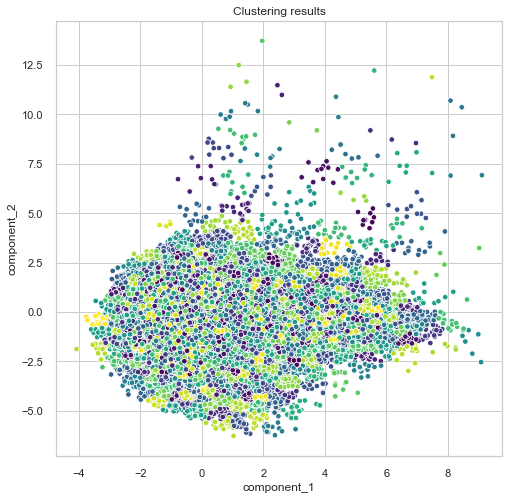

In [36]:
# plotting 
pcadf = pd.DataFrame(kmeans_pipe["pca_preprocessor"].transform(df), columns=["component_1", "component_2"])
pcadf["predicted_cluster"] = kmeans_pipe["kmeans"].labels_

#plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
"component_1",
"component_2",
s=30,
data=pcadf,
hue="predicted_cluster",
palette="viridis")

scat.set_title("Clustering results")
scat.legend_.remove()

plt.savefig('figures/cluster.png')
plt.show()

## Cluster database

In [14]:
# divide the data into clusters using the pipe
cluster_database = df.copy()
cluster_database['clusters']= kmeans_pipe.predict(cluster_database[numeric_features+categoric_features])

# saving cluster database to csv
cluster_database.to_csv("data/cluster_database.csv", sep = ',')

cluster_database['clusters'].value_counts()

9      913
405    882
376    871
142    863
599    860
      ... 
92       2
797      2
911      1
749      1
652      1
Name: clusters, Length: 1000, dtype: int64

In [15]:
# getting a random (audio) sample of 5 tracks in one cluster
indices = cluster_database[cluster_database['clusters'] == randrange(1000)].sample(5).index

for idx in list(indices):
    print(df['preview_url'][idx])


https://p.scdn.co/mp3-preview/1a740ff1712ab8f5231d6269f72b4a3eb772ce56?cid=774b29d4f13844c495f206cafdad9c86
https://p.scdn.co/mp3-preview/de231584a6a99588c161e6e564a478002fd631ab?cid=774b29d4f13844c495f206cafdad9c86
https://p.scdn.co/mp3-preview/590edc7e0e85793df2286bf391b99be469523949?cid=774b29d4f13844c495f206cafdad9c86
https://p.scdn.co/mp3-preview/2cae2666120268f87f9e50679ca8b21a32bb8fcb?cid=774b29d4f13844c495f206cafdad9c86
https://p.scdn.co/mp3-preview/46efa8b6233cf4e68b7f9ee2c6c5fced84c392e0?cid=774b29d4f13844c495f206cafdad9c86


In [16]:
cluster_database.head()

,acousticness,album,album_track_no,artists,artists_id,available_markets,cover_url,danceability,duration_ms,energy,...,tempo,time_signature,total_album_tracks,track_id,genres,place_in_album,month,main_genres,no_genres,clusters
0,0.857000,A00/ No Mind,1,Superposition,7B74HjlZ4Kiy6oKndiiRqL,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",https://i.scdn.co/image/ab67616d0000b273de69d6...,0.0914,310682,0.1370,...,64.645,4.0,8,0yxF1Hwtaq2sNIHziDJuDA,[],0.125000,9.0,unspecified,0,523
1,0.705000,A00/ No Mind,2,Superposition,7B74HjlZ4Kiy6oKndiiRqL,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",https://i.scdn.co/image/ab67616d0000b273de69d6...,0.0946,232516,0.1130,...,72.090,4.0,8,2jrtZWBC8pDJE79b5ryFPY,[],0.250000,9.0,unspecified,0,523
2,0.823000,A00/ No Mind,4,Superposition,7B74HjlZ4Kiy6oKndiiRqL,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",https://i.scdn.co/image/ab67616d0000b273de69d6...,0.0608,305474,0.0299,...,70.334,3.0,8,3UkcCzhObfPbJVEC3HwPYp,[],0.500000,9.0,unspecified,0,993
3,0.000131,Dopamine,11,RX-101,1nxxFDcQjl85Vn3PSZs651,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",https://i.scdn.co/image/ab67616d0000b273938cef...,0.7110,321601,0.6040,...,105.015,4.0,13,7sRneGpHQfduwPxqGLQ293,['braindance'],0.846154,3.0,other,1,503
4,0.000919,Ibiza 2019,14,Various Artists,0LyfQWJT6nXafLPZqxe9Of,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",https://i.scdn.co/image/ab67616d0000b273adf0bc...,0.6600,410952,0.7780,...,126.005,4.0,35,0Lt17oIjz48NzjcxIF8GeP,[],0.400000,10.0,unspecified,0,606
